### imports

In [1]:
import glob
import shutil
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import PIL

### create necessary files

In [2]:
base_dir = os.path.join('fresh_or_rotten')

train_dir = os.path.join(base_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [4]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_img_dir)
create_dir(train_label_dir)

create_dir(test_dir)
create_dir(test_img_dir)
create_dir(test_label_dir)

### visualize the data

In [5]:
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/dataset'

In [6]:
fruit_count=[]
fruit_name=[]
for i in os.listdir(dataset_path+'/train'):
    fruit_name.append(i)
    fruit_count.append(len(os.listdir(os.path.join(dataset_path+'/train', i))))

In [7]:
fruit_df = pd.DataFrame({'fruit_name':fruit_name, 'fruit_count':fruit_count})

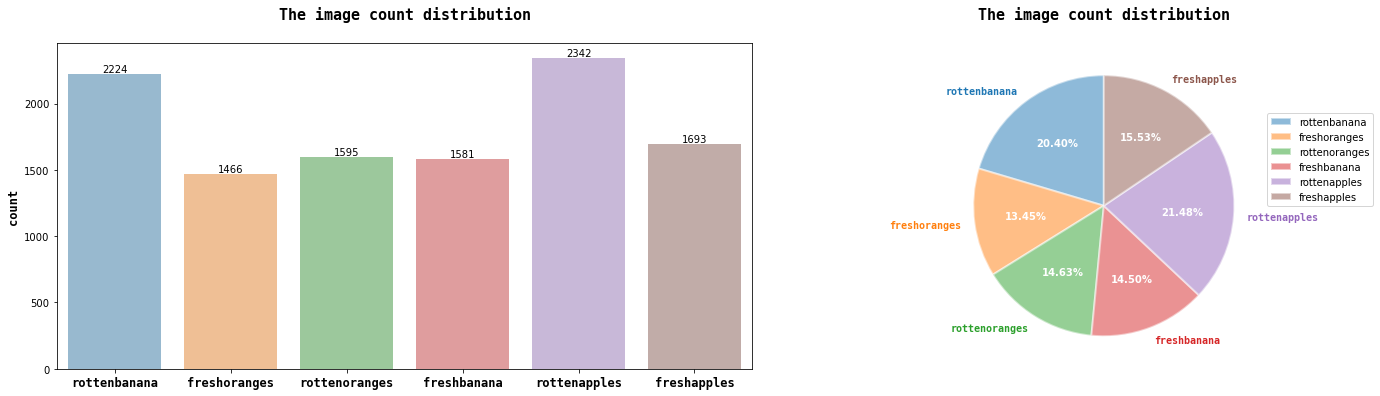

In [8]:
fig,axes = plt.subplots(1,2,figsize=(25,6), gridspec_kw=dict(wspace=0.005))
sns.barplot(data=fruit_df, x='fruit_name', y='fruit_count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(fruit_df['fruit_count'], labels=fruit_df['fruit_name'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### create yolo required dataframe

In [9]:
def get_image_range(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], dtype = "uint8")
    upper = np.array([255, 50, 255], dtype = "uint8")
    img = cv2.inRange(img, lower, upper)
    img = cv2.blur(img, (2, 2))
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))
    
    #get bounding box posotion
    xmin, ymin, xmax, ymax = cv2.boundingRect(contours)
    
    #get the original width,height of the image
    dimensions = img.shape
    h = img.shape[0]
    w = img.shape[1]
    
    #to calculate the bndBox info of this image for yolo
    xp = (xmin + (xmax-xmin)/2) * 1.0 / w
    yp = (ymin + (ymax-ymin)/2) * 1.0 / h
    wp = (xmax-xmin) * 1.0 / w
    hp = (ymax-ymin) * 1.0 / h
    return xp, yp, wp, hp

In [10]:
for dirname, _, filenames in os.walk(dataset_path):
    if dirname[1:].split('/')[-2]=='train':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(train_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'freshbanana':
                label=1
            elif img_path.split('/')[-2] == 'freshoranges':
                label=2
            elif img_path.split('/')[-2] == 'rottenapples':
                label=3
            elif img_path.split('/')[-2] == 'rottenbanana':
                label=4
            elif img_path.split('/')[-2] == 'rottenoranges':
                label=5
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(train_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)
                
    if dirname[1:].split('/')[-2]=='test':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(test_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'freshbanana':
                label=1
            elif img_path.split('/')[-2] == 'freshoranges':
                label=2
            elif img_path.split('/')[-2] == 'rottenapples':
                label=3
            elif img_path.split('/')[-2] == 'rottenbanana':
                label=4
            elif img_path.split('/')[-2] == 'rottenoranges':
                label=5
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(test_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)

In [11]:
print(f'There are {len(os.listdir(train_img_dir))} train images')
print(f'There are {len(os.listdir(train_label_dir))} corresponding train labels\n')

print(f'There are {len(os.listdir(test_img_dir))} train images')
print(f'There are {len(os.listdir(test_label_dir))} corresponding test labels')

There are 10901 train images
There are 10901 corresponding train labels

There are 2698 train images
There are 2698 corresponding test labels


In [12]:
df = pd.DataFrame({'file':['train', 'test'], 'count':[len(os.listdir(train_img_dir)),len(os.listdir(test_img_dir))]})

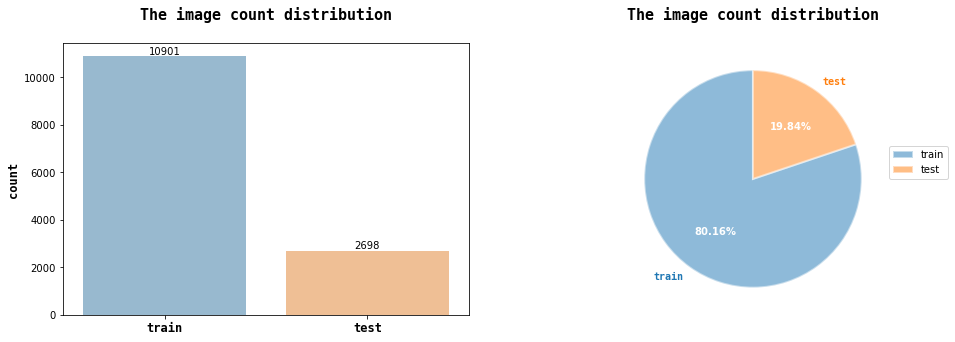

In [13]:

fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df.reset_index(), x='file', y='count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['count'], labels=df['file'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

### remove some files

In [14]:
for path in os.listdir(train_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_img_dir, path))
# after many tests, I realized that images with these key words were not properly annotated 

In [15]:
for path in os.listdir(test_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_img_dir, path))

In [16]:
for path in os.listdir(train_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_label_dir, path))

In [17]:
for path in os.listdir(test_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_label_dir, path))

In [18]:
plan_to_delete_from_train = random.sample([i for i in os.listdir(train_img_dir)], 550)
plan_to_delete_from_test = random.sample([i for i in os.listdir(test_img_dir)], 230)

In [19]:
for i in plan_to_delete_from_train:
    os.remove(os.path.join(train_img_dir, i))
    os.remove(os.path.join(train_label_dir, i[:-4]+'.txt'))

In [20]:
for i in plan_to_delete_from_test:
    os.remove(os.path.join(test_img_dir, i))
    os.remove(os.path.join(test_label_dir, i[:-4]+'.txt'))

In [21]:
print(f'There are {len(os.listdir(train_img_dir))} train images')
print(f'There are {len(os.listdir(train_label_dir))} corresponding train labels\n')

print(f'There are {len(os.listdir(test_img_dir))} train images')
print(f'There are {len(os.listdir(test_label_dir))} corresponding test labels')

There are 632 train images
There are 632 corresponding train labels

There are 99 train images
There are 99 corresponding test labels


### see the images

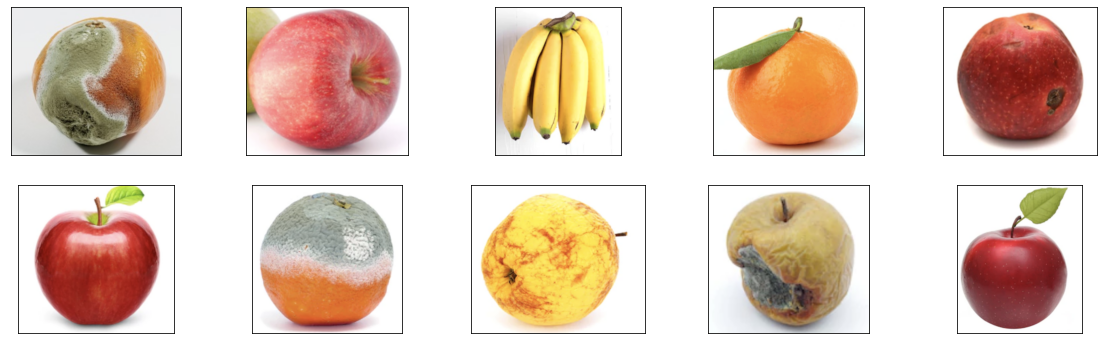

In [22]:
img_path=[]
selected_img = random.sample([i for i in os.listdir(train_img_dir)], 10)
for i in selected_img:
    img_path.append(os.path.join(train_img_dir, i))


fig, axes = plt.subplots(2,5, figsize=(20,6), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(PIL.Image.open(img_path[i])))

### create the yaml file for yolo

In [23]:
yaml_file = """names: 
- fresh_apples 
- fresh_banana
- fresh_oranges
- rotten_apples
- rotten_banana
- rotten_oranges
nc: 6
train: /kaggle/working/fresh_or_rotten/train/images
val: /kaggle/working/fresh_or_rotten/test/images
"""

with open('/kaggle/working/fresh_or_rotten/data.yaml', 'w') as f:
    f.write(yaml_file)

In [24]:
with open(os.path.join(train_label_dir, os.listdir(train_label_dir)[0]),'r') as f:
    c = f.read()
    print(c)

2 0.4557291666666667 0.5 0.7552083333333334 0.96875


### train yolo model

In [25]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 6.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-ext

In [26]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output
! yolo checks

Ultralytics YOLOv8.0.35 🚀 Python-3.7.12 torch-1.11.0+cpu CPU
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 4221.3/8062.4 GB disk)


In [27]:
conda install pytorch torchvision torchaudio -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    ffmpeg-4.3                 |       hf484d3e_0         9.9 MB  pytorch
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.6.13              |       h85f3911_1         2.0 MB  conda-forge
    lame-3.100                 |    h166bdaf_1003         496 KB  conda-forge
    libblas-3.9.0              |   16_linux64_mkl          13 KB  conda-forge
    libcblas-3.9.0             |   16_linux64_mkl          

In [28]:
! yolo task=detect mode=train model=yolov8x.pt data=/kaggle/working/fresh_or_rotten/data.yaml epochs=8 imgsz=640 

100%|████████████████████████████████████████| 131M/131M [00:03<00:00, 34.5MB/s]
Ultralytics YOLOv8.0.35 🚀 Python-3.7.12 torch-1.13.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/fresh_or_rotten/data.yaml, epochs=8, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

### see the results

In [29]:
os.listdir('/kaggle/working/runs/detect/train')

['val_batch1_labels.jpg',
 'weights',
 'args.yaml',
 'val_batch0_pred.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_pred.jpg',
 'confusion_matrix.png',
 'PR_curve.png',
 'train_batch0.jpg',
 'events.out.tfevents.1676176572.8fc42c647c9b.11702.0',
 'val_batch0_labels.jpg',
 'val_batch2_labels.jpg',
 'train_batch2.jpg',
 'results.png',
 'results.csv',
 'R_curve.png',
 'train_batch1.jpg',
 'P_curve.png',
 'F1_curve.png']

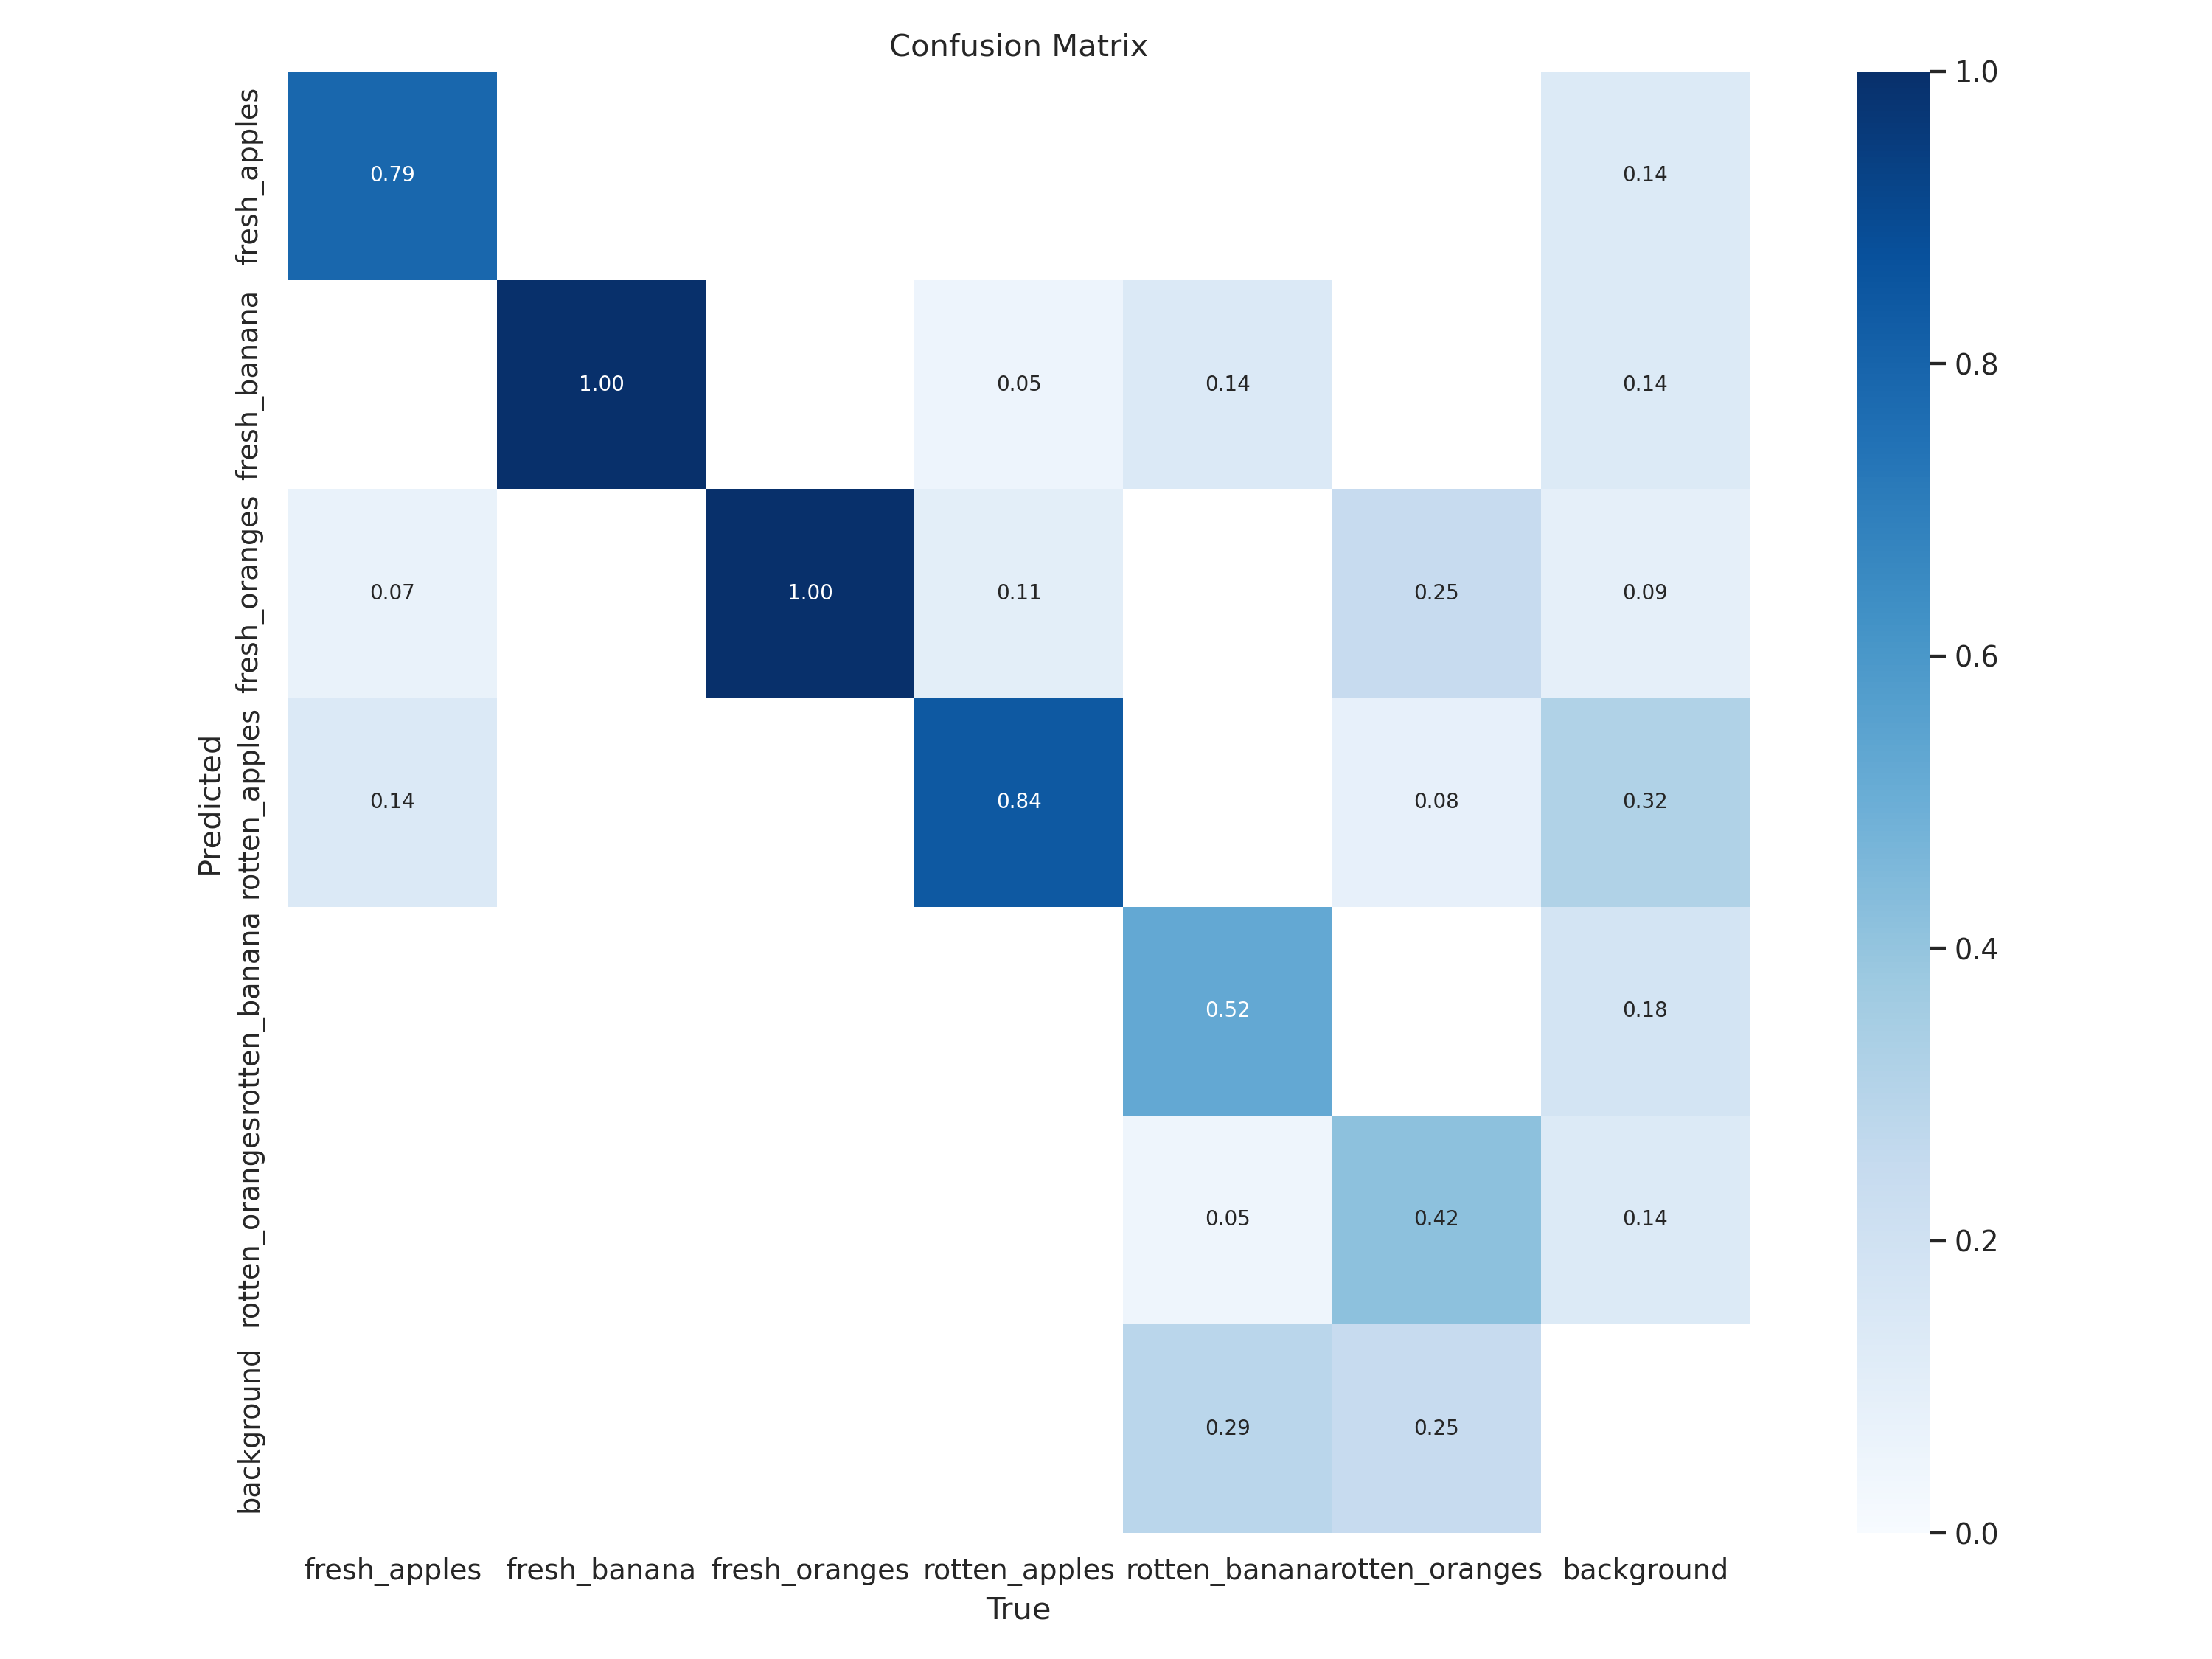

In [30]:
Image('/kaggle/working/runs/detect/train/confusion_matrix.png')

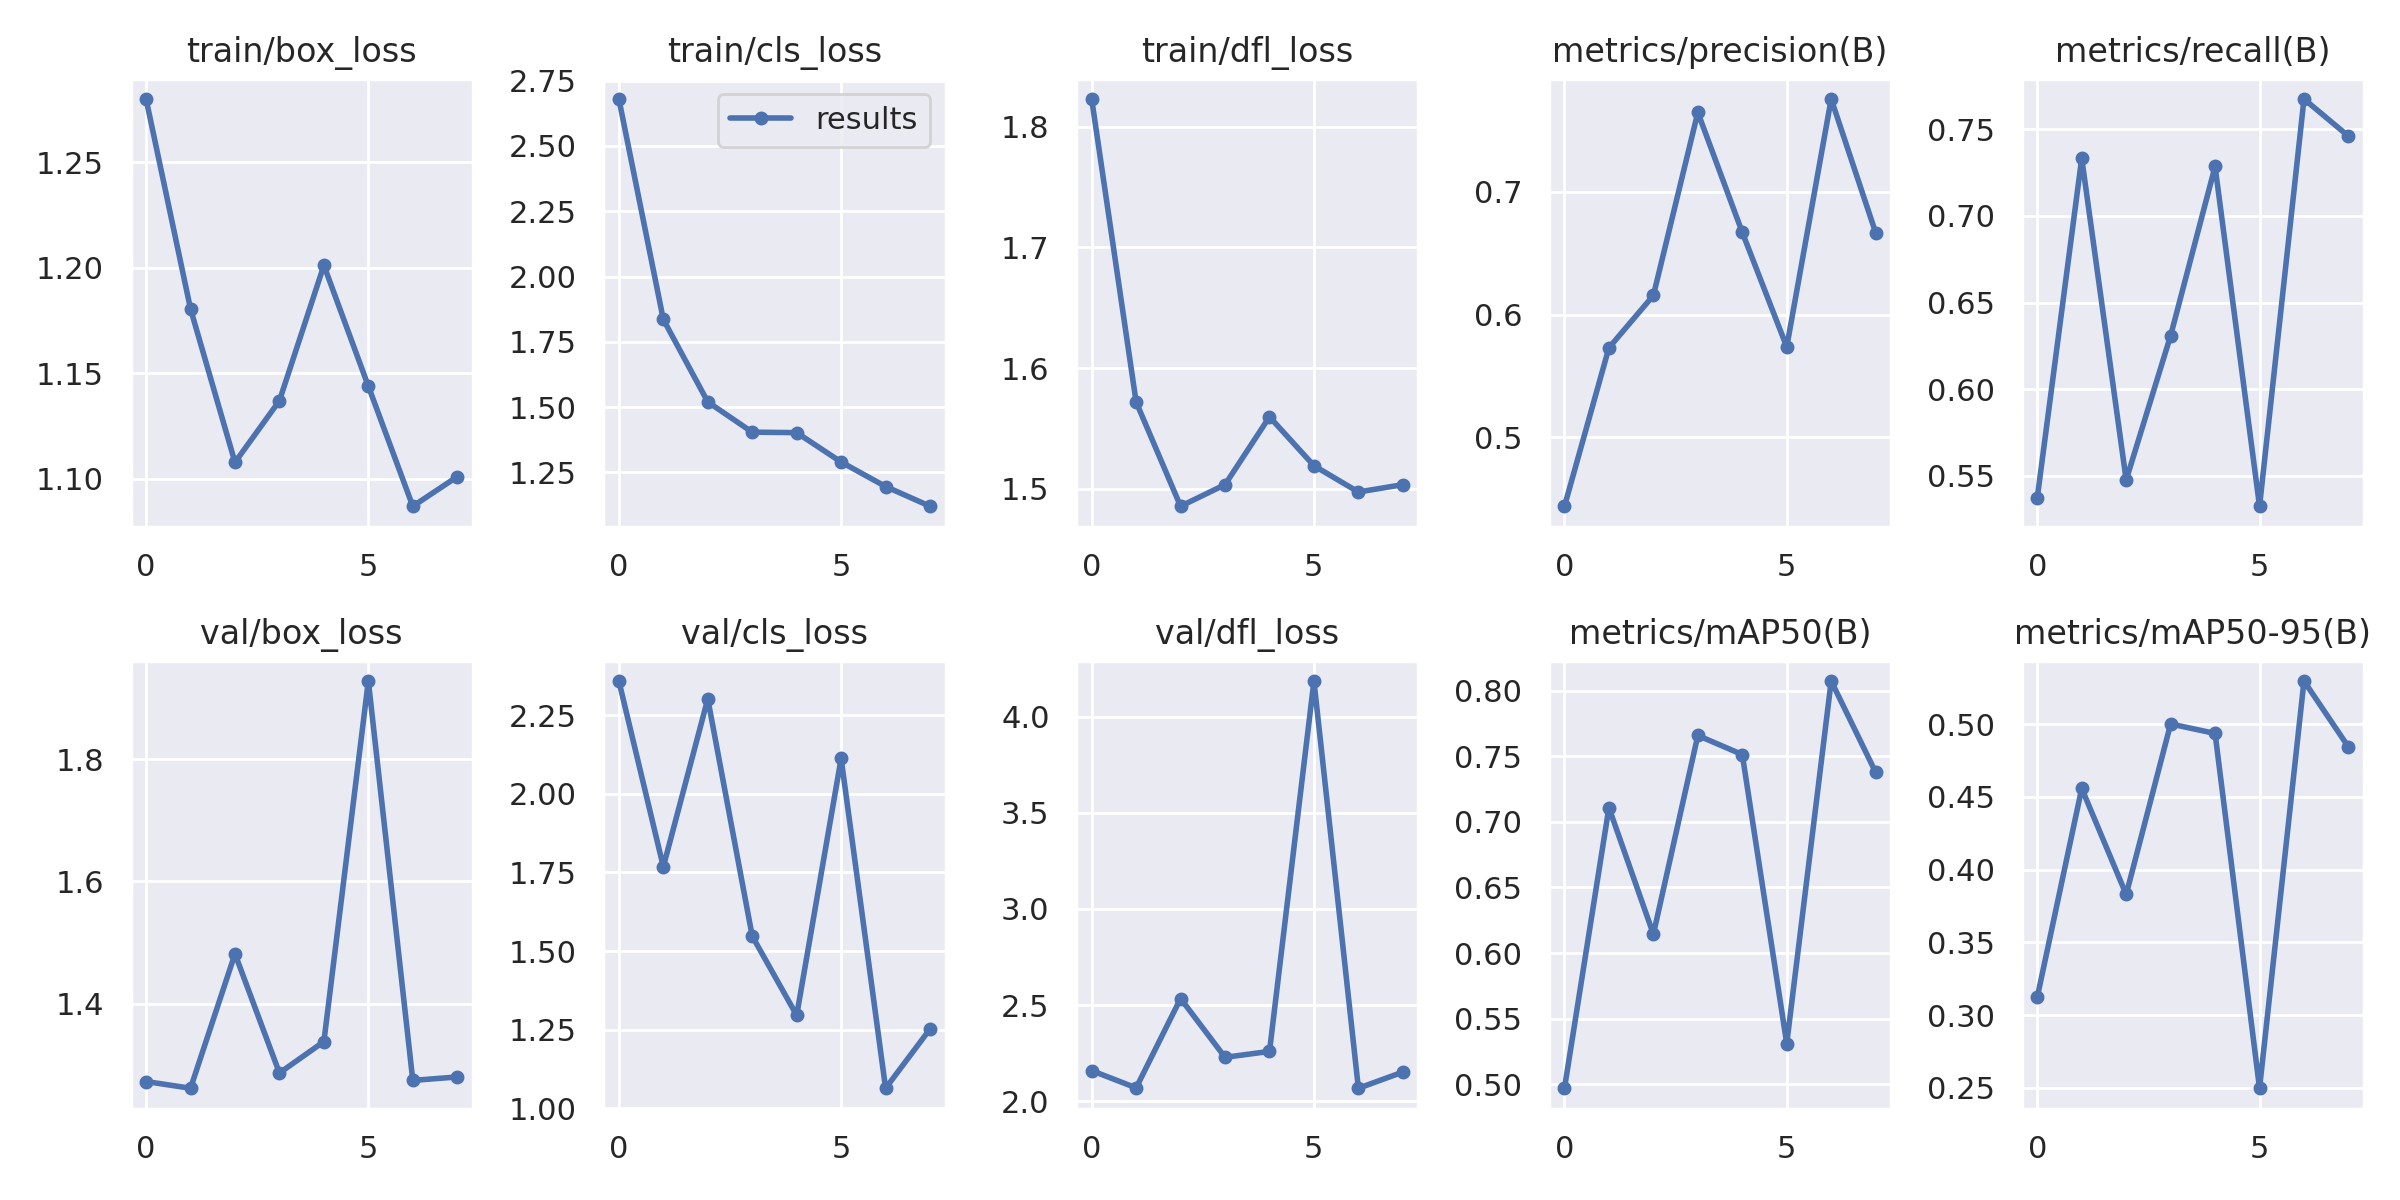

In [31]:
Image('/kaggle/working/runs/detect/train/results.png')

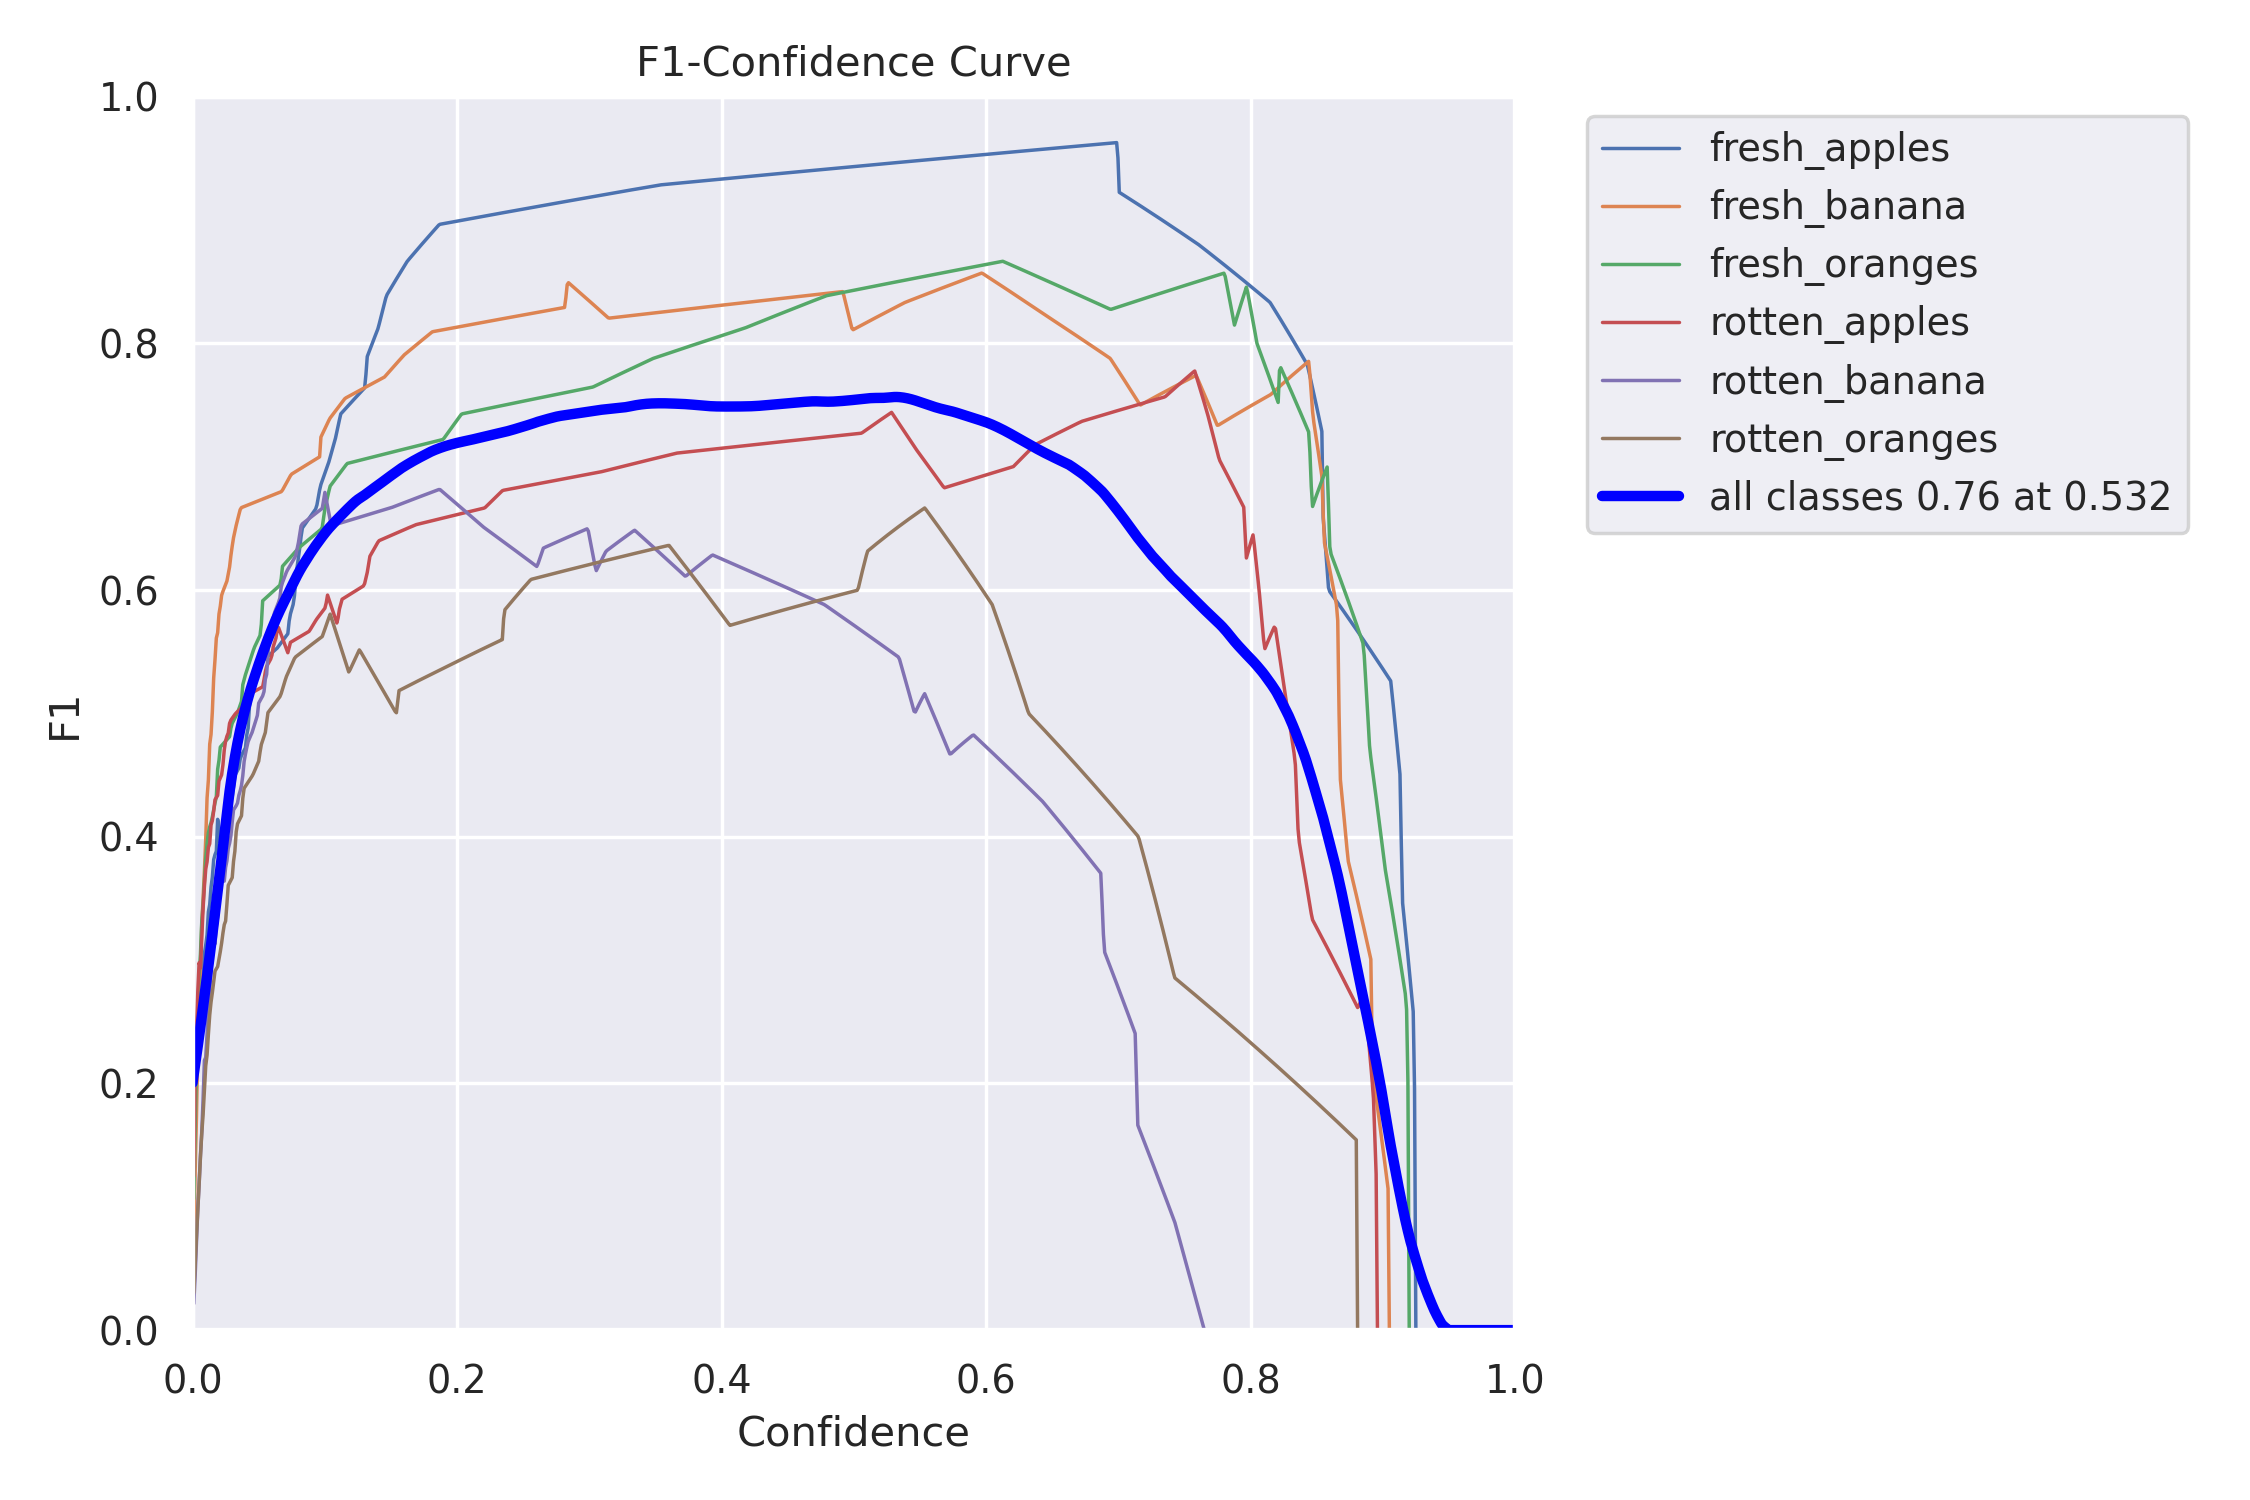

In [32]:
Image(filename = '/kaggle/working/runs/detect/train/F1_curve.png')

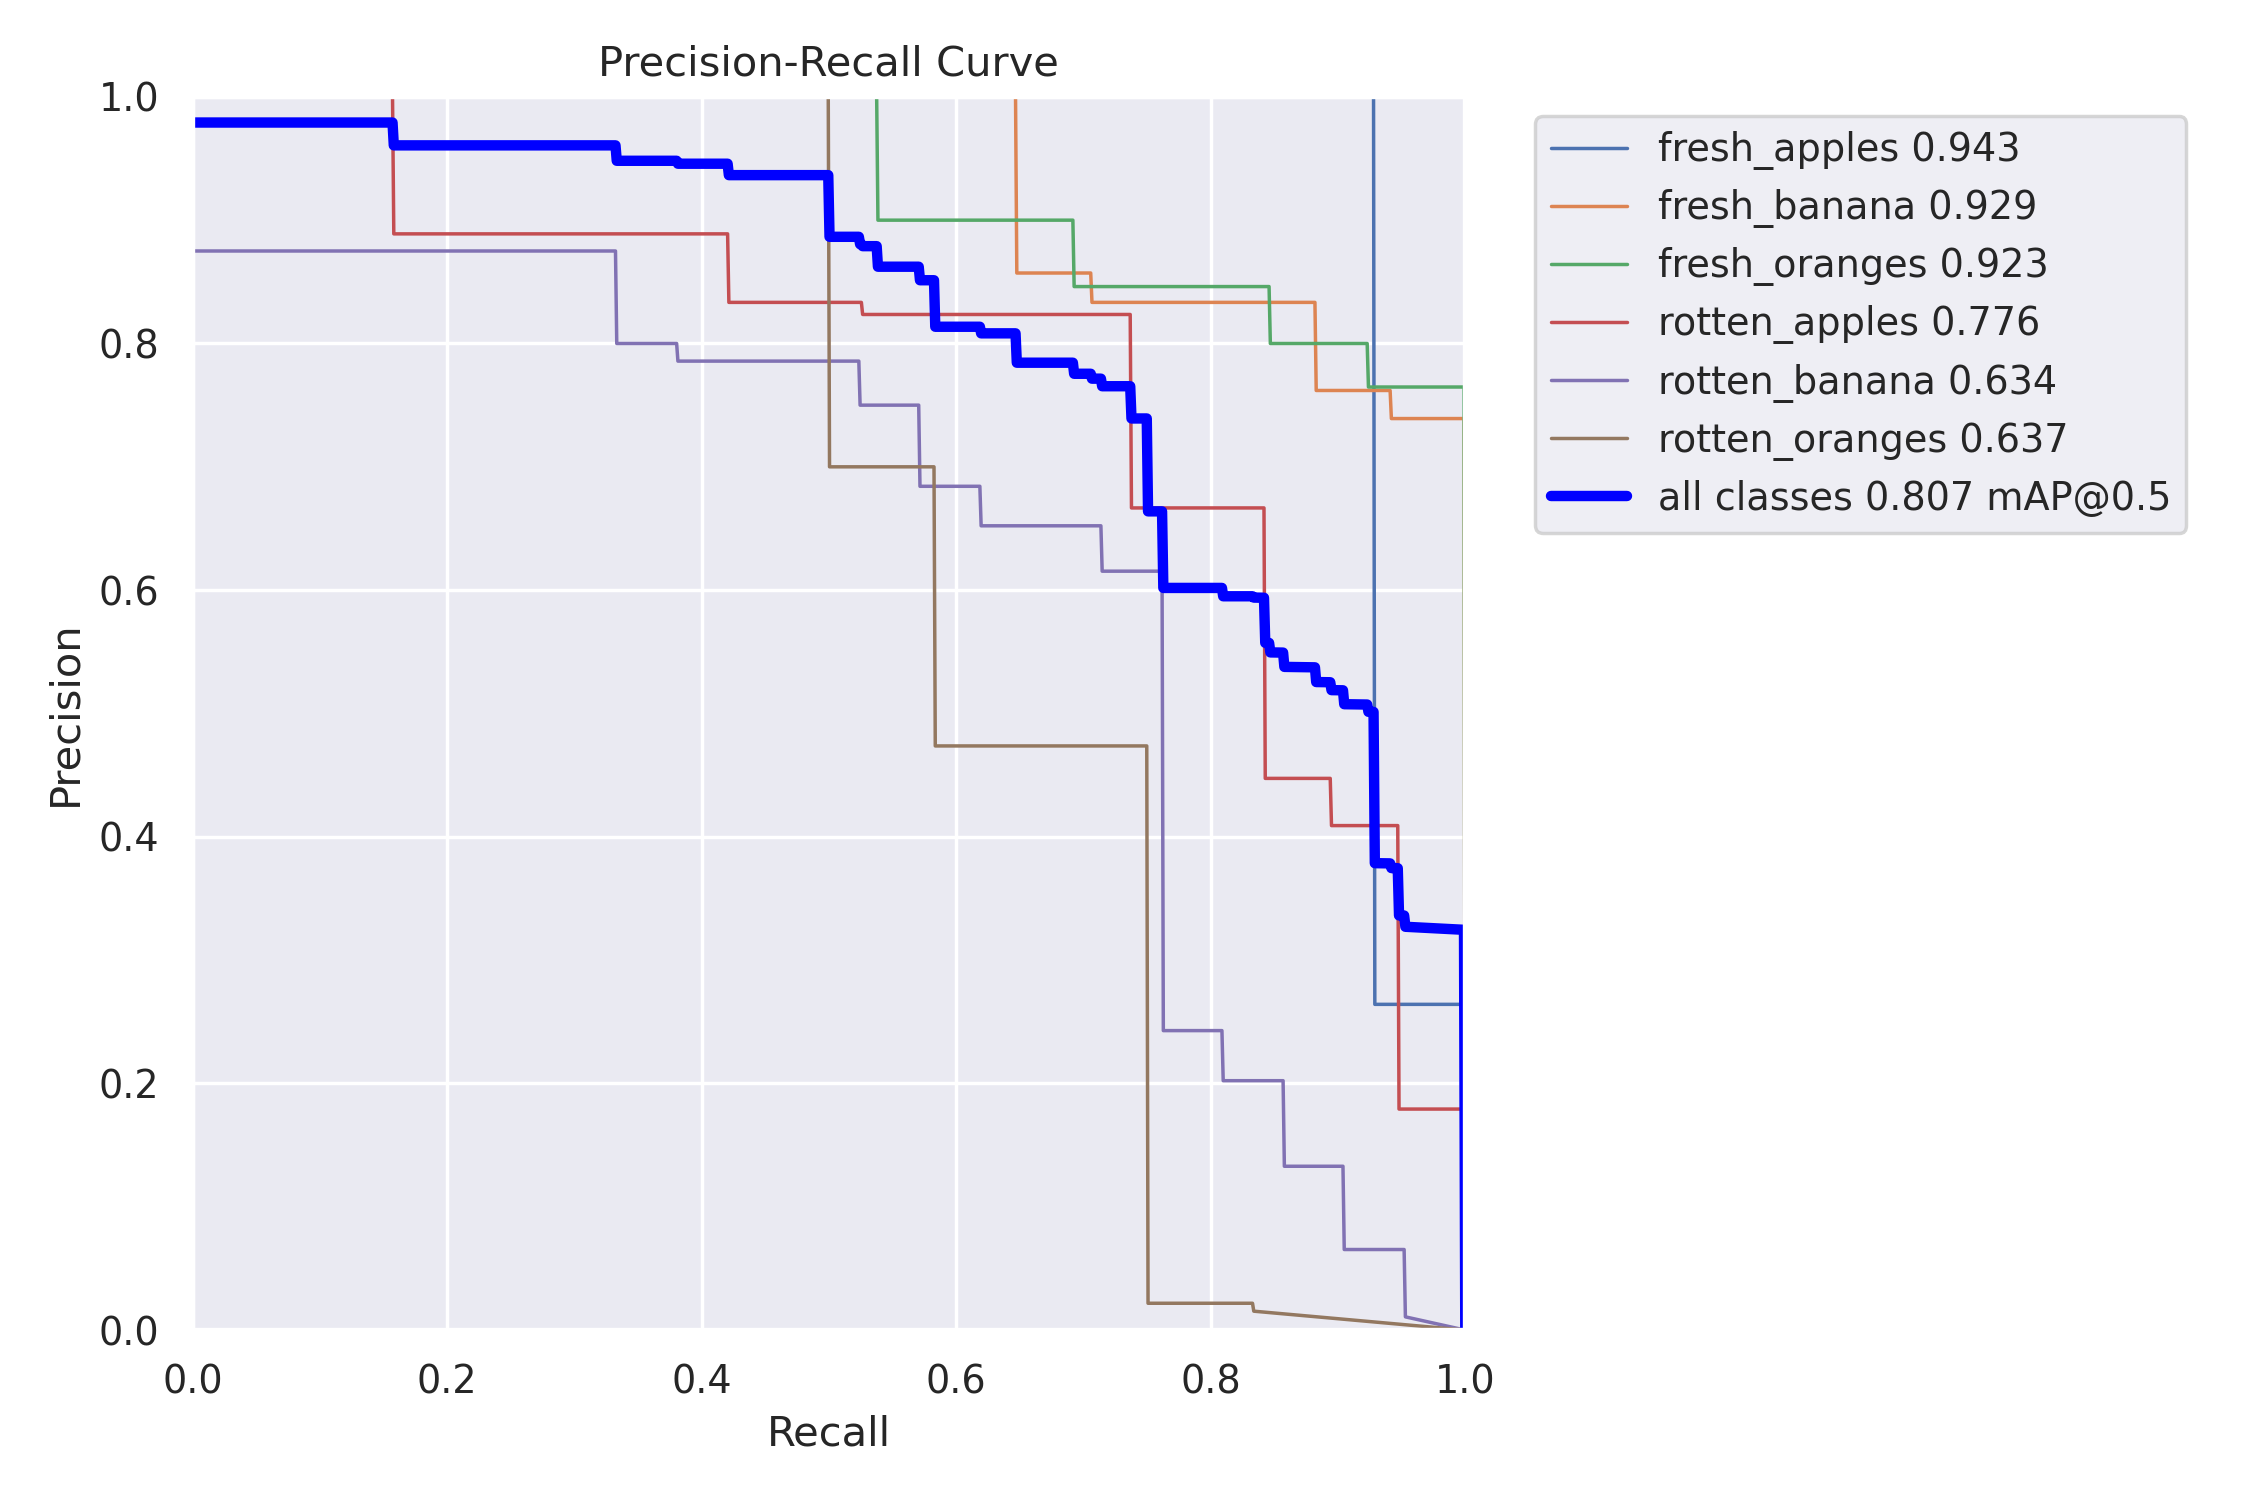

In [33]:
Image(filename = '/kaggle/working/runs/detect/train/PR_curve.png')

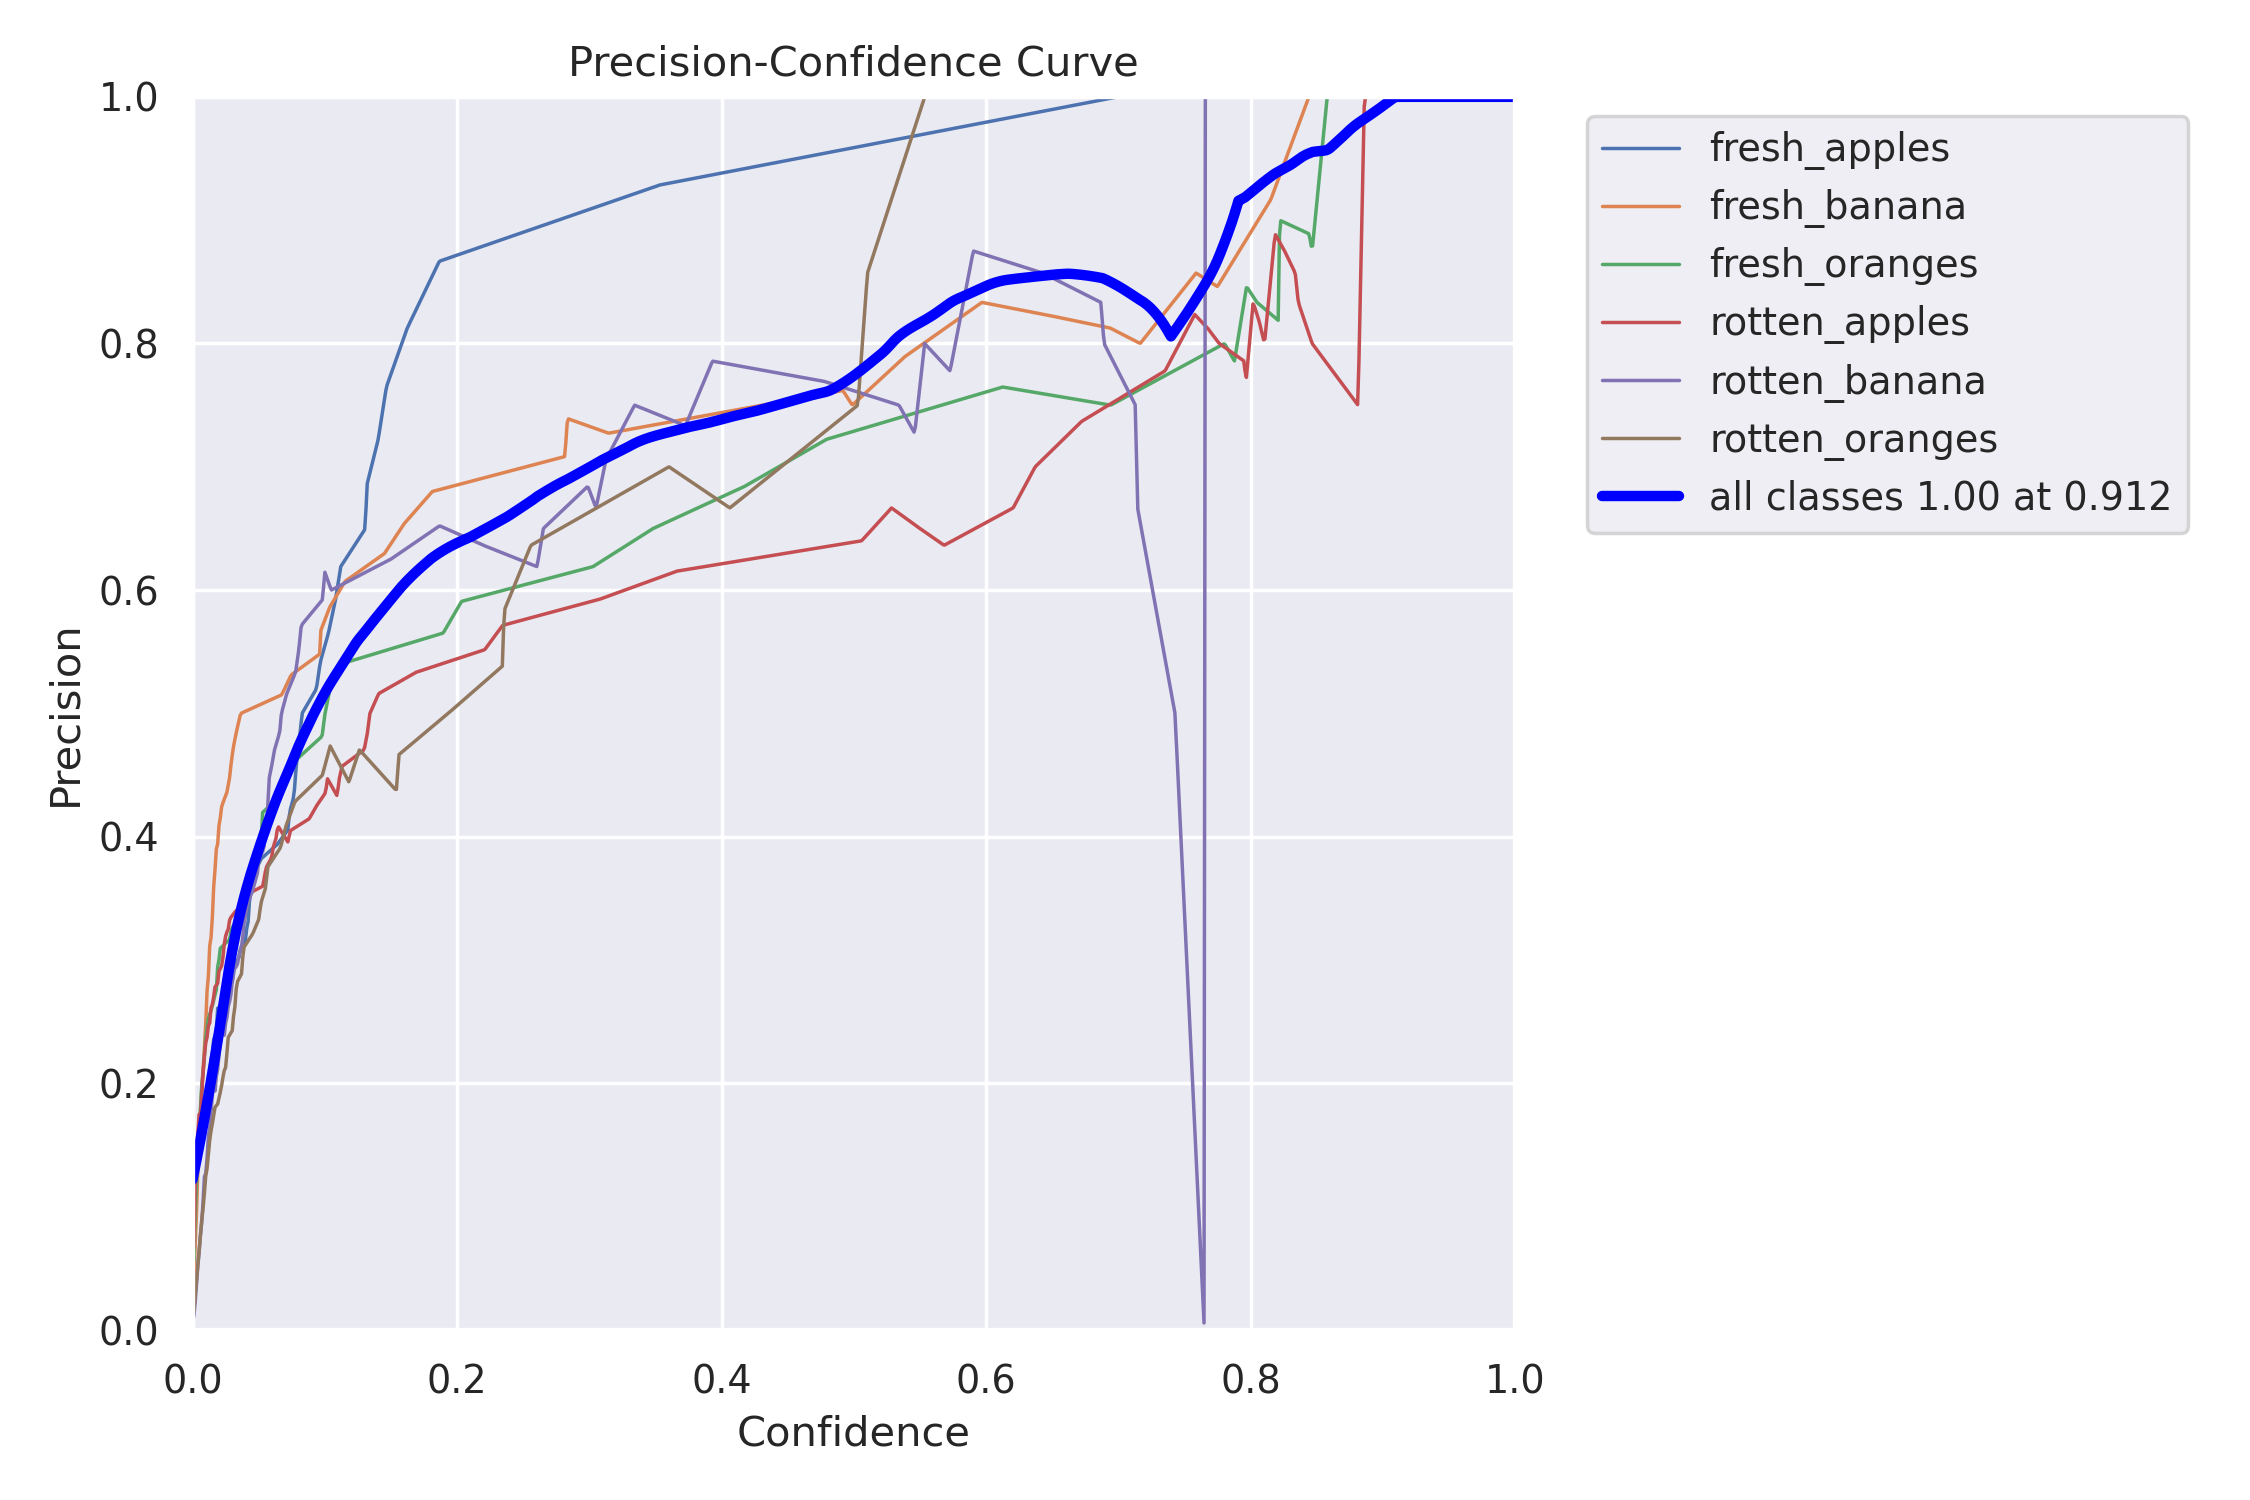

In [34]:
Image(filename = '/kaggle/working/runs/detect/train/P_curve.png')

In [35]:
shutil.copy('/kaggle/working/runs/detect/train/weights/best.pt','/kaggle/working')

'/kaggle/working/best.pt'

In [36]:
! yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=/kaggle/working/fresh_or_rotten/data.yaml

Ultralytics YOLOv8.0.35 🚀 Python-3.7.12 torch-1.13.1 CPU
Model summary (fused): 268 layers, 68129346 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /kaggle/working/fresh_or_rotten/test/labels.cache... 99 images, 0 
val: WARNING ⚠️ /kaggle/working/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 8.51.00 PM.png: ignoring corrupt image/label: negative label values [  -0.079096]
val: WARNING ⚠️ /kaggle/working/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 8.52.16 PM.png: ignoring corrupt image/label: negative label values [   -0.27548]
val: WARNING ⚠️ /kaggle/working/fresh_or_rotten/test/images/Screen Shot 2018-06-12 at 9.25.41 PM.png: ignoring corrupt image/label: negative label values [   -0.44322     -0.2878]
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         96         96       0.77      0.771      0.805      0.522
          fresh_apples         96         14      0.962      0.929      0.943      0.709
     

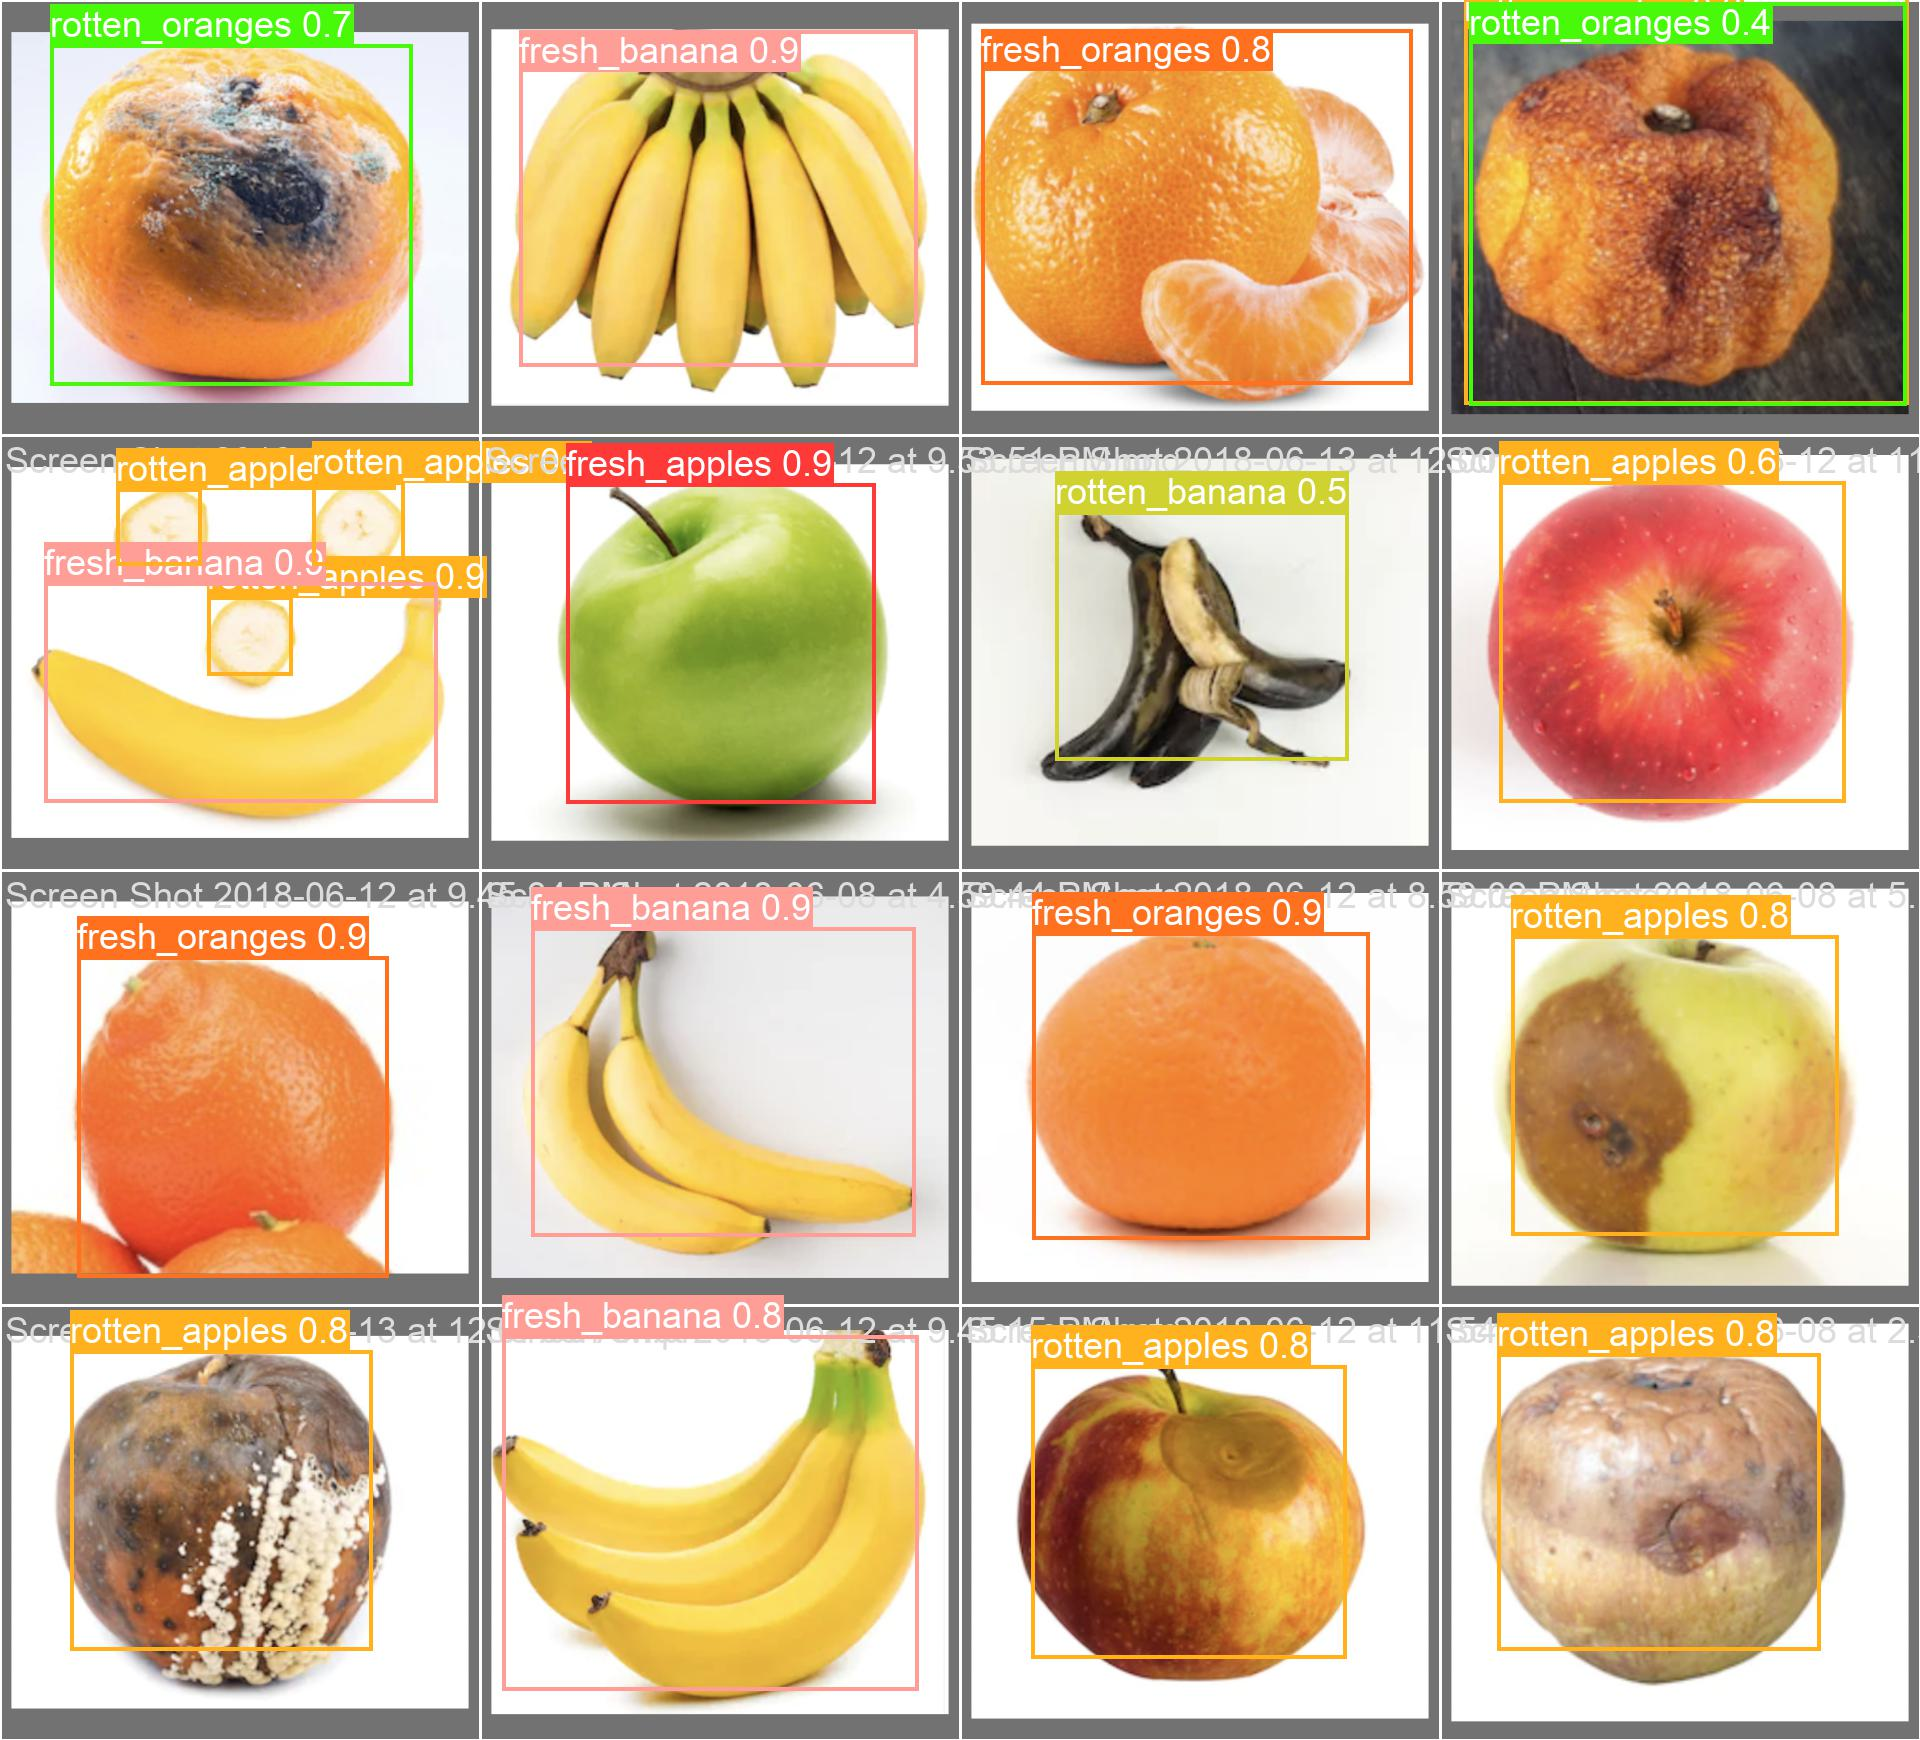

In [37]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch1_pred.jpg')

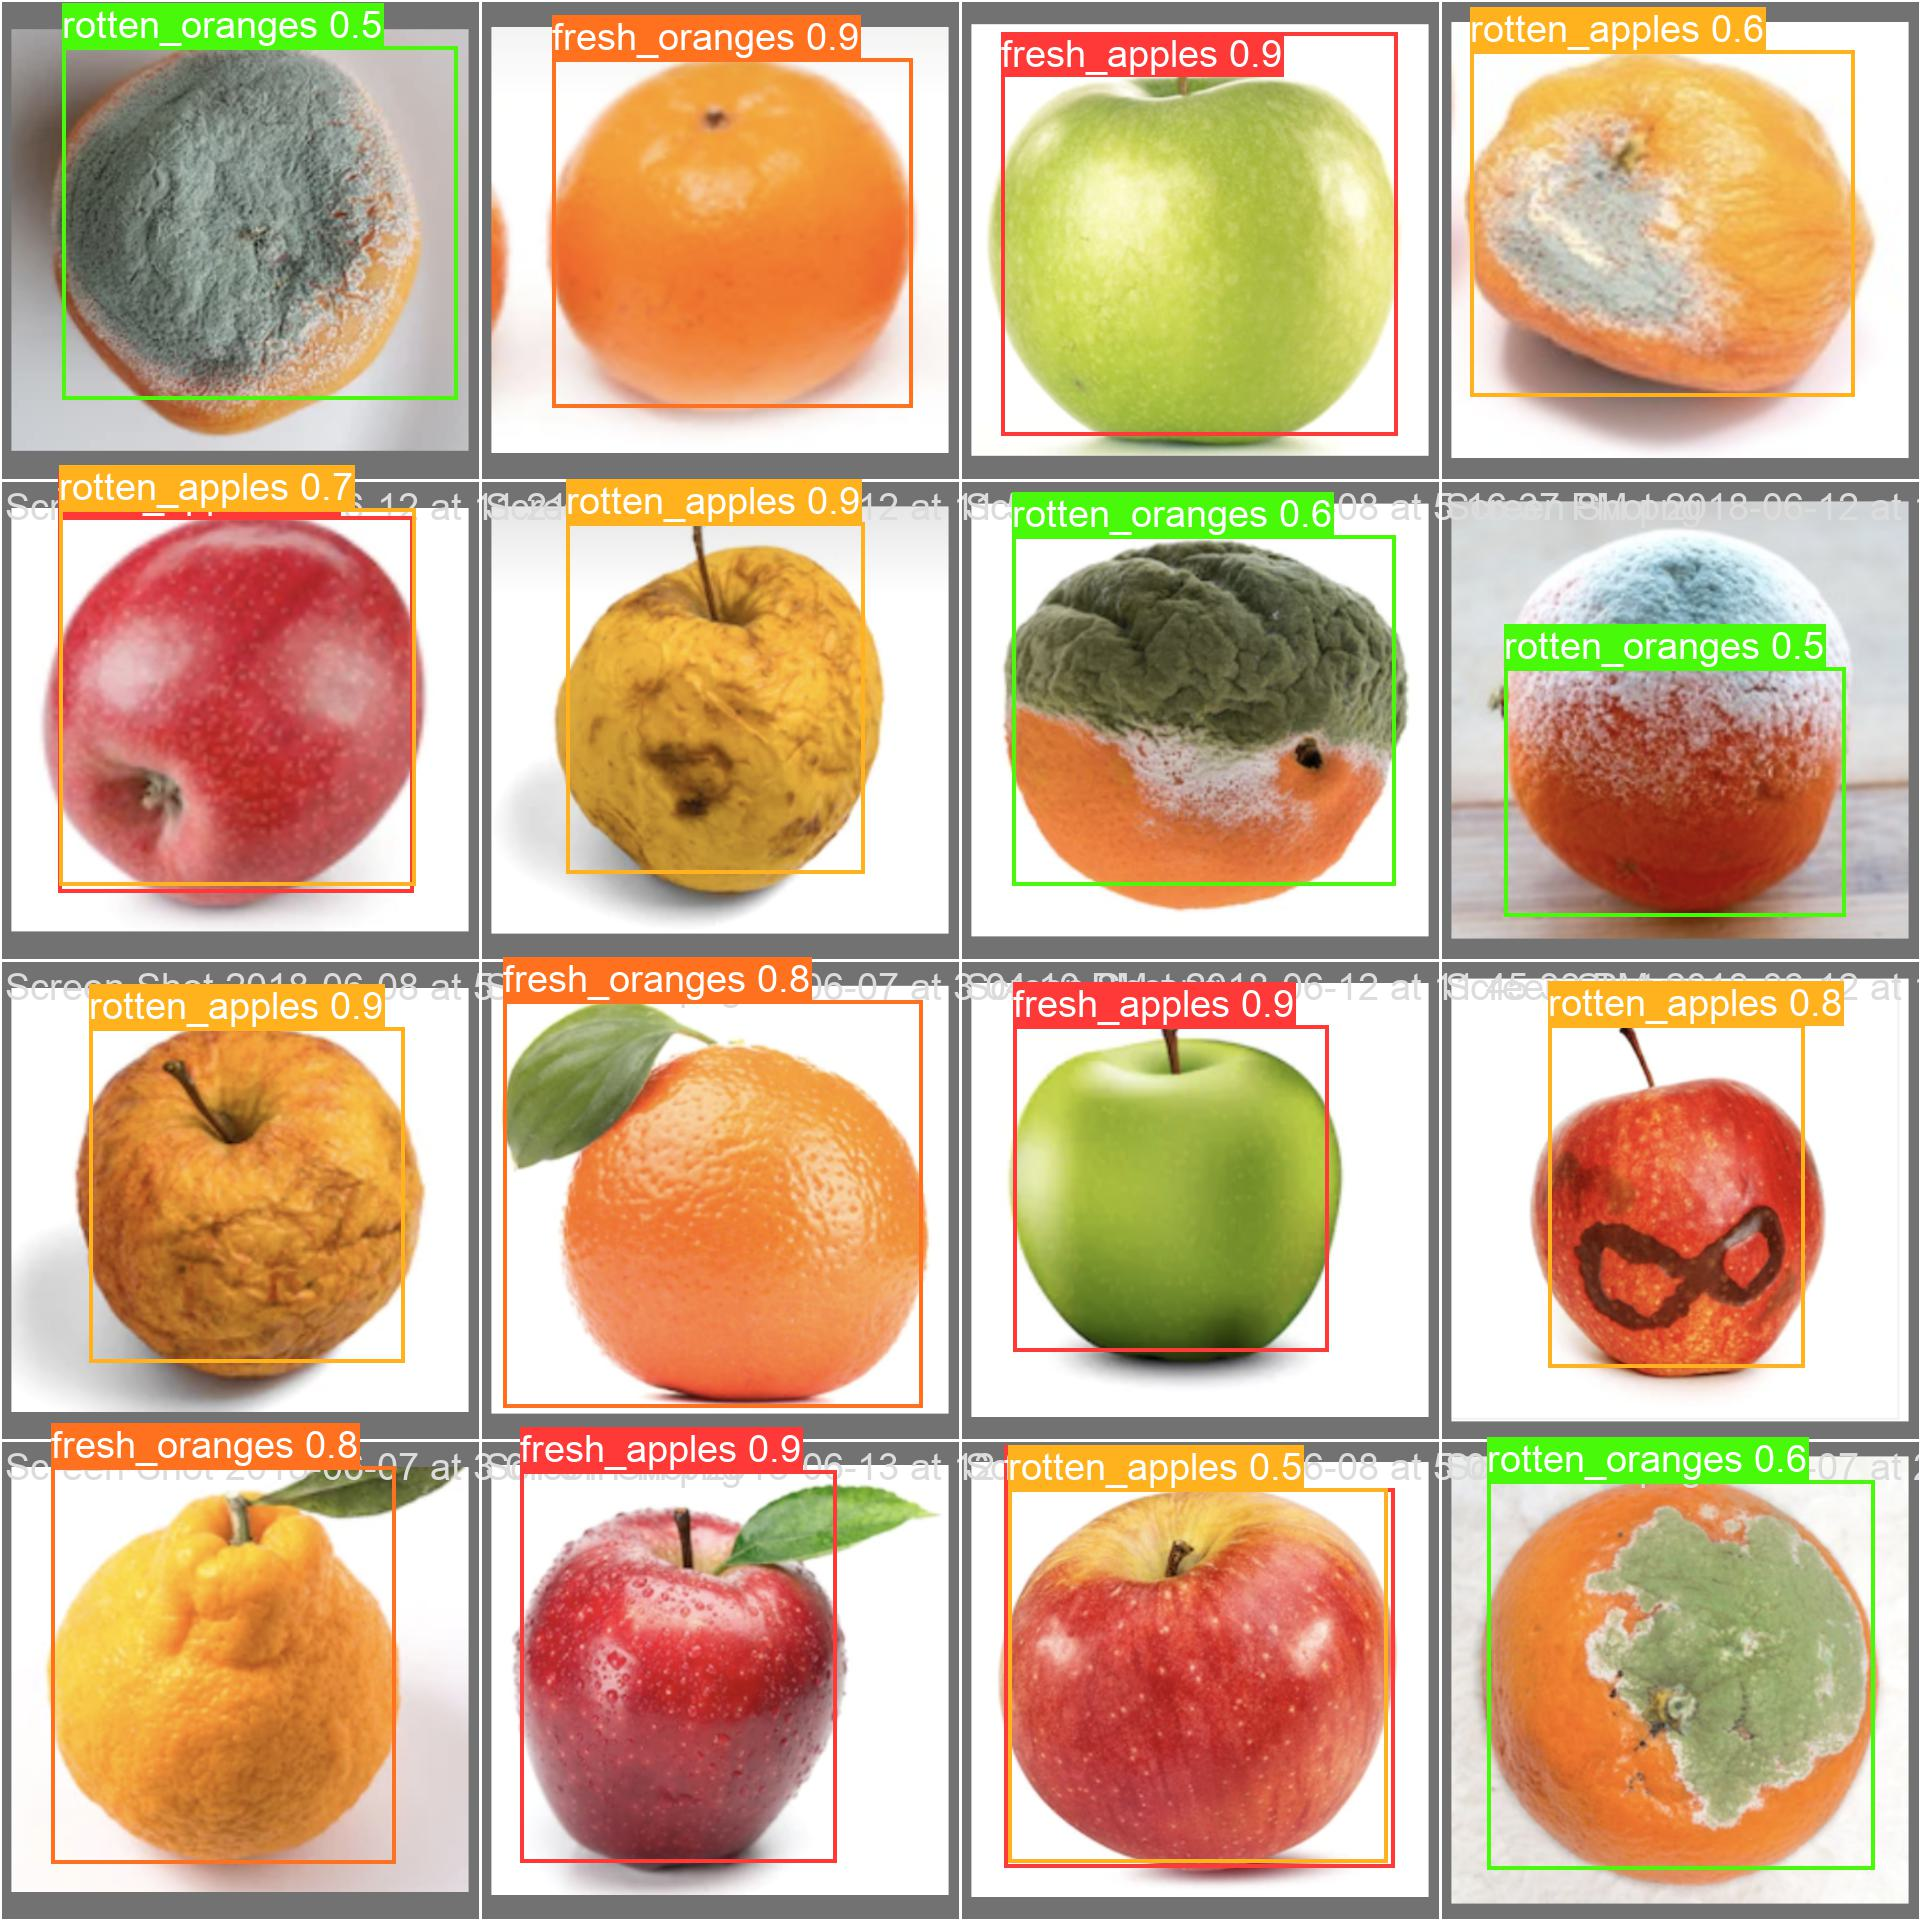

In [38]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch2_pred.jpg')

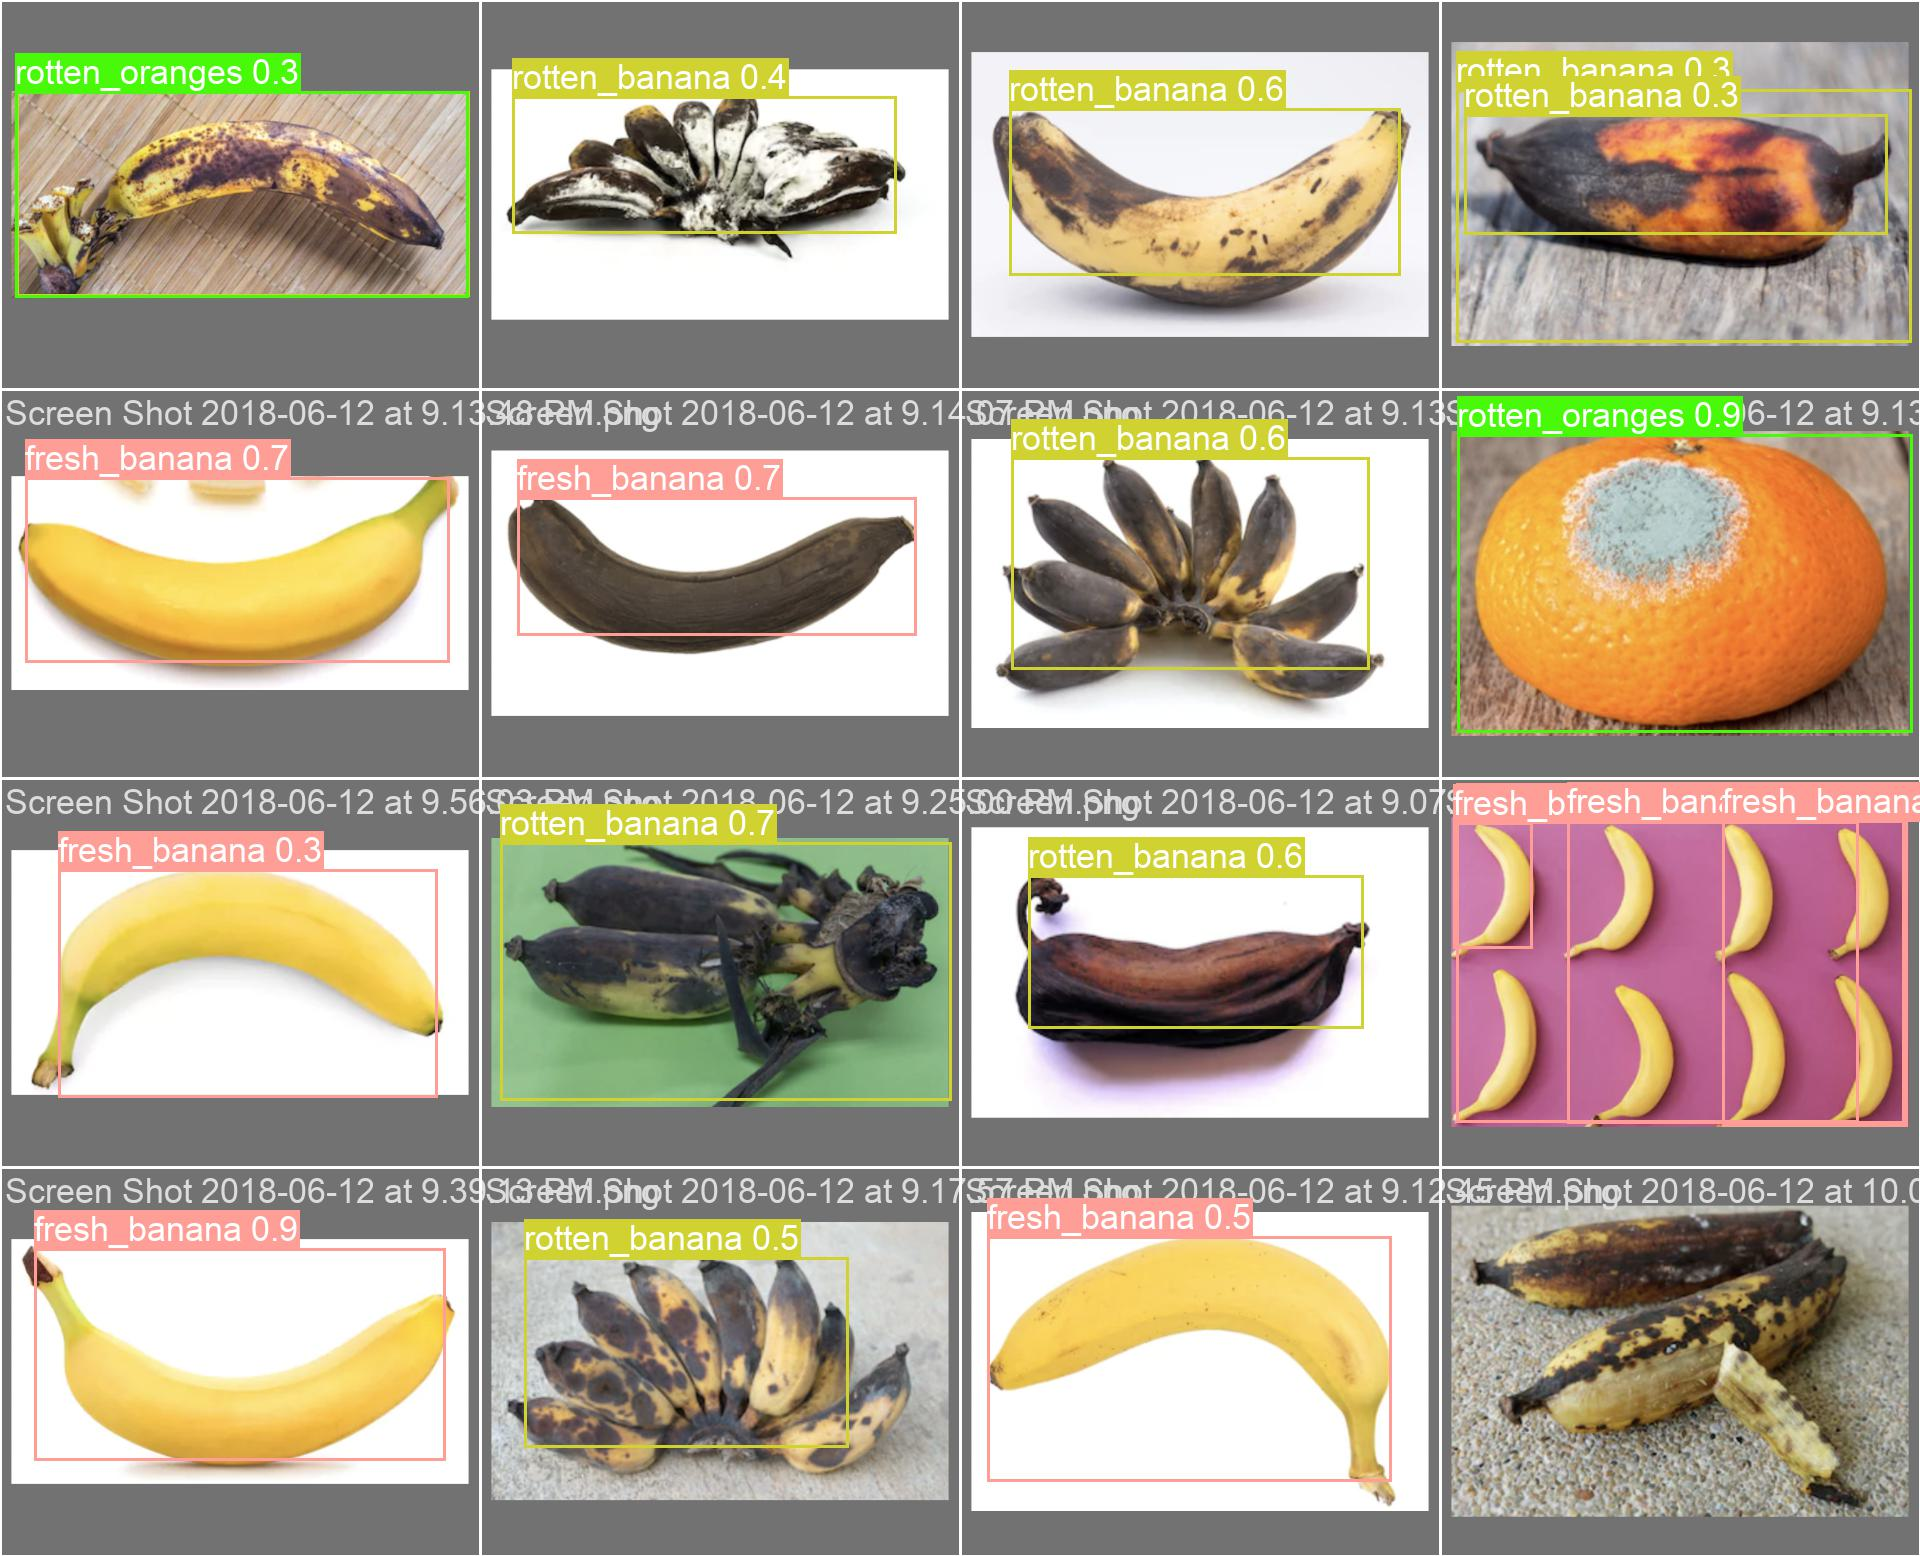

In [39]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch0_pred.jpg')